In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from datetime import datetime

# Clustering des transactions bancaires

In [4]:
# Script pour transformer le fichier Donnees_test.xlsx excel en un fichier csv sur le bon format en
# classant les numéros societaires de maniere unique et de calculer aussi la moyenne des transactions
# le nombre de transactions et la recence depuis le 17/06/2025 sur notre exemple 
# 1. Chargement du fichier 
df = pd.read_excel("Donnees_test.xlsx") 
df.rename(columns={
    "N° Societaire": "societaire",
    "Montant": "montant",
    "Créée le": "date_transaction"
}, inplace=True)
df["date_transaction"] = pd.to_datetime(df["date_transaction"], errors="coerce")
# Date de référence = aujourd'hui
# ici si on veut on peut ajouter d'autres parametres qu'on veut visualiser 
today = pd.Timestamp.today().normalize()
agg = df.groupby("societaire").agg(
    montant_moyen=("montant", "mean"),
    nb_transactions_mois=("montant", "count"),
    dernière_transaction=("date_transaction", "max")
).reset_index()
# calcul recence en jours
agg["dernière_transaction_jour"] = (today - agg["dernière_transaction"]).dt.days
agg.to_csv("base_reelles.csv", index=False, encoding="utf-8")
print("Fichier transformé et sauvegardé : base_reelles.csv")


Fichier transformé et sauvegardé : base_reelles.csv


In [5]:
# Permet de transformer le fichier bases_reelles.csv en bases_reelles_bis.csv qui aura le bon format
# pour appliquer l'algo de clustering sur les données collectées

df = pd.read_csv("bases_reelles.csv")
# Renommage des colonnes
df.rename(columns={"societaire": "client_id"}, inplace=True)
# conversion en entier pour les moyennes
df["montant_moyen"] = df["montant_moyen"].round(0).astype(int)
# transformation de la date en format JJ/MM/AAAA
df["dernière_transaction"] = pd.to_datetime(df["dernière_transaction"], errors="coerce")
df["dernière_transaction"] = df["dernière_transaction"].dt.strftime("%d/%m/%Y")
# Réorganisation des colonnes
df = df[["client_id", "montant_moyen", "dernière_transaction", "nb_transactions_mois", "dernière_transaction_jour"]]
# Ici on remplace les séparations par des ; pour que ça soit bien traités lors de la lecture du fichier en utf-8
output_file = "bases_reelles_bis.csv"
df.to_csv(output_file, sep=";", index=False, encoding="utf-8")
print(f"Fichier correctement formaté : {output_file}")


Fichier correctement formaté : bases_reelles_bis.csv



Colonnes disponibles dans le CSV :
['client_id', 'montant_moyen', 'derniÃ¨re_transaction', 'nb_transactions_mois', 'derniÃ¨re_transaction_jour']


/var/folders/4c/fh9xd7z13n95s2n9x83k0j640000gn/T/ipykernel_30095/981809335.py:14: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.




 Nombre total de clusters détectés : 22

Liste des clusters et effectifs :
1. Faible montant / faible activité / intermédiaire (926 clients)
2. Faible montant / faible activité / récent (1424 clients)
3. Faible montant / moyen activité / intermédiaire (849 clients)
4. Faible montant / moyen activité / récent (1353 clients)
5. Fidèles réguliers (activité élevée, montant moyen) (4241 clients)
6. Moyen montant / faible activité / ancien (1813 clients)
7. Moyen montant / faible activité / intermédiaire (1383 clients)
8. Moyen montant / faible activité / récent (851 clients)
9. Moyen montant / moyen activité / ancien (1062 clients)
10. Moyen montant / moyen activité / intermédiaire (1558 clients)
11. Moyen montant / moyen activité / récent (1500 clients)
12. Moyen montant / élevé activité / ancien (434 clients)
13. Petits mais actifs (faible montant, très actifs) (4988 clients)
14. Premium dormants (haut montant, peu actifs, anciens) (2991 clients)
15. VIP (montant élevé, très actifs, réce

/var/folders/4c/fh9xd7z13n95s2n9x83k0j640000gn/T/ipykernel_30095/981809335.py:75: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



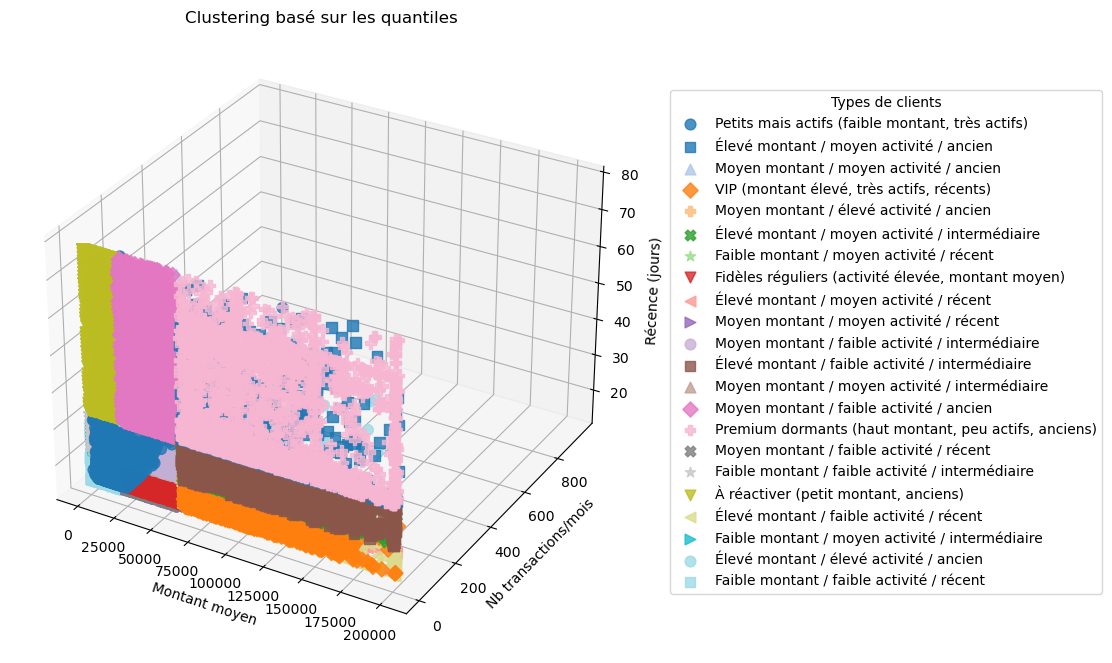


 Résultats sauvegardés dans resultats_bases_reelles_fin.csv (colonnes nettoyées)


In [7]:
# Script principal contenant l'algo de clustering. Le principe est tout d'abord à partir des données qu'on a
# de calculer les quantiles (1er, 2e et 3e) où le premier représente les valeurs inférieurs à 33% de l'ensemble des
# valeurs que la population possède, le deuxième celles inférieures à 66% et la trosième celles inférieures à 100%
# ensuite pour chaque identifiant, on classifie chaqu'un de ses paramètres pour donner son caractère relatif à l'ensemble de la population
# A la fin on décide par rapport aux caractéristiques des paramètres de chaque individi quel type de cluster ou classe il appartient
# Deux graphes en 3D dont l'un qui est intéractif est à disposition pour visualiser ces données classifiées sous forme de nuages de points
# 1. Chargement des données
df = pd.read_csv("bases_reelles_fin.csv", encoding="latin1", sep=";")
print("\nColonnes disponibles dans le CSV :")
print(df.columns.tolist())
# renommation des colonnes dûes à des bugs sur le caractère "é"
df = df.rename(columns={"derniÃ¨re_transaction": "derniere_transaction"})
df = df.rename(columns={"derniÃ¨re_transaction_jour": "derniere_transaction_jour"})
df["derniere_transaction"] = pd.to_datetime(df["derniere_transaction"], errors="coerce")
# Calcul de la récence
today = pd.Timestamp.today().normalize()
df["derniere_transaction_jour"] = (today - df["derniere_transaction"]).dt.days
# Colonnes numériques à traiter
cols_num = ["montant_moyen", "nb_transactions_mois", "derniere_transaction_jour"]
for col in cols_num:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=cols_num)
# 2. calclu des quantiles (seuils globaux)
q_montant = np.quantile(df["montant_moyen"], [1/3, 2/3])
q_freq    = np.quantile(df["nb_transactions_mois"], [1/3, 2/3])
q_rec     = np.quantile(df["derniere_transaction_jour"], [1/3, 2/3])
def level_from_terciles(x, terciles):
    if x <= terciles[0]:
        return "faible"
    elif x <= terciles[1]:
        return "moyen"
    else:
        return "élevé"
def level_recence_from_terciles(x, terciles):
    if x <= terciles[0]:
        return "récent"
    elif x <= terciles[1]:
        return "intermédiaire"
    else:
        return "ancien"
# 3. caractérisation des paramètres de chaque client
df["montant_cat"] = df["montant_moyen"].apply(lambda x: level_from_terciles(x, q_montant))
df["freq_cat"]    = df["nb_transactions_mois"].apply(lambda x: level_from_terciles(x, q_freq))
df["rec_cat"]     = df["derniere_transaction_jour"].apply(lambda x: level_recence_from_terciles(x, q_rec))
# 4. clustering ou classification des clients (ce sont mes classifications mais on peut enlever ou rajouter
# d'autres noms de clusters)
# ------------------------
def assign_cluster_name(montant, freq, rec):
    if montant == "élevé" and freq == "élevé" and rec != "ancien":
        return "VIP (montant élevé, très actifs, récents)"
    elif montant == "élevé" and freq == "faible" and rec == "ancien":
        return "Premium dormants (haut montant, peu actifs, anciens)"
    elif montant == "moyen" and freq == "élevé" and rec in ("récent", "intermédiaire"):
        return "Fidèles réguliers (activité élevée, montant moyen)"
    elif montant == "faible" and freq == "élevé":
        return "Petits mais actifs (faible montant, très actifs)"
    elif montant == "faible" and rec == "ancien":
        return "À réactiver (petit montant, anciens)"
    else:
        return f"{montant.capitalize()} montant / {freq} activité / {rec}"
df["cluster_name"] = df.apply(lambda row: assign_cluster_name(row["montant_cat"], row["freq_cat"], row["rec_cat"]), axis=1)
# 5. Numéro de cluster unique 
df["cluster"] = df["cluster_name"].astype("category").cat.codes
# 6. Résumé pour print
summary = df.groupby("cluster_name")[cols_num].agg(['mean','median','count'])
n_clusters = df["cluster_name"].nunique()
print(f"\n Nombre total de clusters détectés : {n_clusters}\n")
print("Liste des clusters et effectifs :")
for i, (name, subset) in enumerate(df.groupby("cluster_name"), 1):
    print(f"{i}. {name} ({len(subset)} clients)")
# 7. Visualisation 3D (Matplotlib)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
from matplotlib.cm import get_cmap
cmap = get_cmap("tab20", df["cluster"].nunique())  
markers = ["o", "s", "^", "D", "P", "X", "*", "v", "<", ">"]
for i, cid in enumerate(df["cluster"].unique()):
    subset = df[df["cluster"] == cid]
    ax.scatter(
        subset["montant_moyen"], 
        subset["nb_transactions_mois"], 
        subset["derniere_transaction_jour"], 
        c=[cmap(i)], 
        s=60, 
        alpha=0.8, 
        marker=markers[i % len(markers)], 
        label=subset["cluster_name"].iloc[0]
    )
ax.set_xlabel("Montant moyen")
ax.set_ylabel("Nb transactions/mois")
ax.set_zlabel("Récence (jours)")
ax.set_title("Clustering basé sur les quantiles")
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Types de clients")
plt.tight_layout()
plt.show()
# Visualisation 3D (Plotly - Interactif)
palette = px.colors.qualitative.Set3 + px.colors.qualitative.Safe + px.colors.qualitative.Bold
df["cluster_display"] = df["cluster_name"]
fig = px.scatter_3d(
    df,
    x="montant_moyen",
    y="nb_transactions_mois",
    z="derniere_transaction_jour",
    color="cluster_display",
    symbol="cluster_display", 
    color_discrete_sequence=palette,
    hover_data={
        "montant_moyen": True,
        "nb_transactions_mois": True,
        "derniere_transaction_jour": True,
        "cluster_name": True
    },
    size_max=12,
    opacity=0.85
)
fig.update_layout(
    title="Clustering basé sur les quantiles - Interactif",
    legend_title_text="Type de clients",
    scene=dict(
        xaxis_title='Montant moyen',
        yaxis_title='Nb transactions/mois',
        zaxis_title='Récence (jours)'
    )
)
fig.show()
# 8. Transformation en fichier resultats_bases_reelles_fin.csv en enlevant les colonnes crées temporairement
# ------------------------
export_cols = [c for c in df.columns if c not in ["montant_cat", "freq_cat", "rec_cat", "cluster_display"]]
output_file = "resultats_bases_reelles_fin.csv"
df[export_cols].to_csv(output_file, index=False, encoding="utf-8", sep=";")
print(f"\n Résultats sauvegardés dans {output_file} (colonnes nettoyées)")


In [8]:
# transformation du fichier csv contenant les résultats du clustering en un fichier excel
csv_file = "resultats_bases_reelles_fin.csv"
excel_file = "resultats_bases_reelles_fin.xlsx"
df = pd.read_csv(csv_file, sep=';', on_bad_lines='skip')
df.to_excel(excel_file, index=False)
print(f" Le fichier Excel a été créé : {excel_file}")



 Le fichier Excel a été créé : resultats_bases_reelles_fin.xlsx
